In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import folium
from folium.plugins import MarkerCluster
import seaborn as sns

# Earthquake Analysis in Turkey Using USGS API
This notebook demonstrates how to retrieve, process, and visualize earthquake data in the Turkey region using the USGS Earthquake API. We’ll focus on magnitudes ≥ 3.0 from January 1, 2024 to today.


Here we define a bounding box that covers Turkey and set a minimum magnitude of 3.0. Data is pulled in GeoJSON format. We extract relevant attributes (time, place, and magnitude) from the GeoJSON structure and convert them into a pandas DataFrame. This time-series graph shows how many earthquakes occurred each day. A histogram of earthquake magnitudes helps us understand how frequent different magnitudes are. We also create an interactive folium map centered on Turkey, where each earthquake is represented by a colored circle marker based on its magnitude. Finally, the map is exported as an HTML file for further exploration.

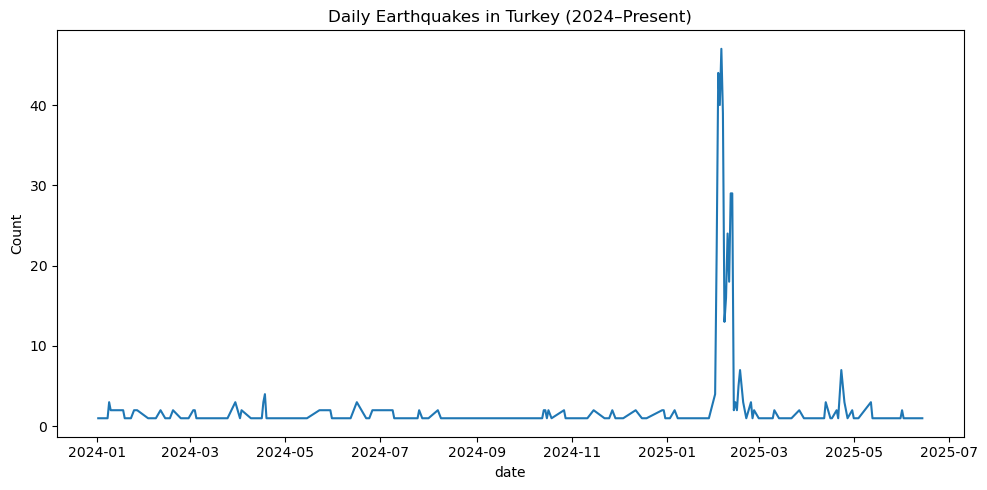

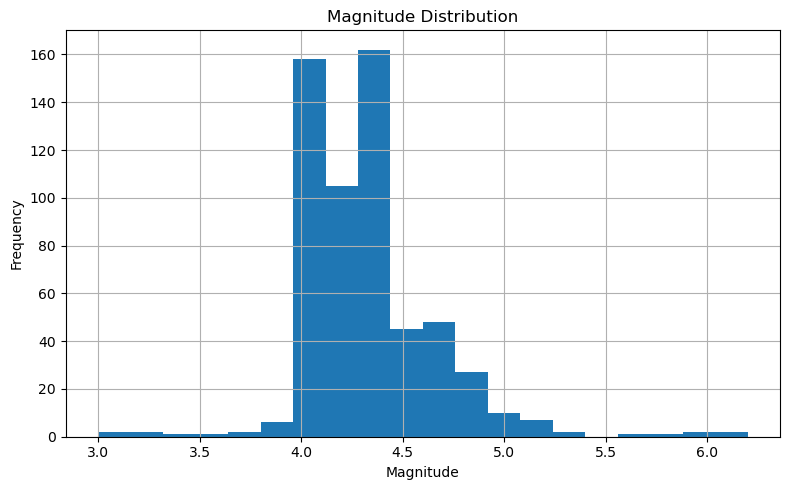

In [30]:
# 2. Fetch earthquake data from USGS for Turkey (2024–present)
starttime = "2024-01-01"
endtime = date.today().strftime("%Y-%m-%d")

url = (
    "https://earthquake.usgs.gov/fdsnws/event/1/query?"
    f"format=geojson&starttime={starttime}&endtime={endtime}"
    f"&minlatitude=35&maxlatitude=43&minlongitude=25&maxlongitude=45"
    f"&minmagnitude=3"
)

response = requests.get(url)
data = response.json()

features = data["features"]
quakes = [{
    "time": pd.to_datetime(f["properties"]["time"], unit="ms"),
    "place": f["properties"]["place"],
    "mag": f["properties"]["mag"],
    "lon": f["geometry"]["coordinates"][0],
    "lat": f["geometry"]["coordinates"][1]
} for f in features]

df = pd.DataFrame(quakes)
df["date"] = df["time"].dt.date  # for time series


# A. Time Series Plot
daily_counts = df.groupby("date").size()
daily_counts.plot(figsize=(10, 5), title="Daily Earthquakes in Turkey (2024–Present)", ylabel="Count")
plt.tight_layout()
plt.savefig("earthquake_time_series.png", dpi=300)
plt.show()

# B. Magnitude Distribution
df["mag"].hist(bins=20, figsize=(8, 5))
plt.title("Magnitude Distribution")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("earthquake_magnitude_distribution.png", dpi=300)
plt.show()

# C. Folium Map
m = folium.Map(location=[39.0, 35.5], zoom_start=6, tiles="CartoDB positron")
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    magnitude = row["mag"]
    color = (
        "red" if magnitude >= 5 else
        "orange" if magnitude >= 4 else
        "blue"
    )
    
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=magnitude * 1.2,
        popup=folium.Popup(
            f"<b>{row['place']}</b><br>Magnitude: {magnitude}<br>Date: {row['time'].date()}",
            max_width=300
        ),
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(marker_cluster)

m.save("turkey_earthquakes_map.html")


Using the folium library and its HeatMap plugin, the code creates a dark-themed heatmap where each point's intensity corresponds to the earthquake’s magnitude. The final map is saved as an interactive HTML file for exploration.

In [31]:
# Initialize a dark-themed Folium map centered on Turkey
m = folium.Map(location=[39.0, 35.5], zoom_start=6, tiles="CartoDB dark_matter")

# Prepare data for the heatmap (latitude, longitude, magnitude)
heat_data = [[row['lat'], row['lon'], row['mag']] for index, row in df.iterrows()]

# Add heatmap layer to the map
HeatMap(heat_data, radius=12).add_to(m)

# Save the interactive map as an HTML file
m.save("turkey_earthquake_heatmap.html")

In [32]:
# Assigns a general region in Turkey based on latitude and longitude.
# If coordinates fall outside defined Turkish regions, returns "Outside Turkey".

def assign_region(lat, lon):
    if 36 <= lat <= 39 and 26 <= lon <= 30:
        return "Aegean"
    elif 36 <= lat <= 40 and 30 < lon <= 37:
        return "Mediterranean"
    elif 36 <= lat <= 39 and 37 < lon <= 45:
        return "Southeastern Anatolia"
    elif 39 < lat <= 42 and 26 <= lon <= 32:
        return "Marmara"
    elif 39 < lat <= 42 and 32 < lon <= 38:
        return "Central Anatolia"
    elif 38 <= lat <= 42 and 38 < lon <= 43:
        return "Eastern Anatolia"
    elif 41 < lat <= 43 and 27 <= lon <= 33:
        return "Black Sea"
    else:
        return "Outside Turkey"


This block assigns each earthquake to a geographical region in Turkey based on its latitude and longitude using the assign_region() function. It then calculates how many earthquakes occurred in each region by using value_counts(), which gives us an overview of regional earthquake distribution.

In [33]:
df["region"] = df.apply(lambda row: assign_region(row["lat"], row["lon"]), axis=1)
region_counts = df["region"].value_counts()
print(region_counts)


region
Outside Turkey           419
Southeastern Anatolia     49
Aegean                    31
Mediterranean             31
Marmara                   23
Central Anatolia          16
Eastern Anatolia          14
Black Sea                  1
Name: count, dtype: int64


This block visualizes earthquakes in Turkey by geographical region using a Folium interactive map. Each earthquake is represented by a colored circle marker, where the color corresponds to its assigned region (e.g., Marmara in blue, Eastern Anatolia in pink). The radius is fixed for all markers, while the popup provides basic information such as the region name and earthquake magnitude. The map is saved as an interactive HTML file named turkey_quakes_by_region.html.

In [35]:
region_colors = {
    "Aegean": "orange",
    "Mediterranean": "green",
    "Southeastern Anatolia": "red",
    "Marmara": "blue",
    "Central Anatolia": "purple",
    "Eastern Anatolia": "pink",
    "Black Sea": "cadetblue",
    "Outside Turkey": "gray"
}

m = folium.Map(location=[39.0, 35.5], zoom_start=6)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color=region_colors.get(row["region"], "gray"),
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['region']} – M{row['mag']}"
    ).add_to(m)

m.save("turkey_quakes_by_region.html")


In [ ]:
print(df.columns)

Index(['lat', 'lon', 'mag', 'region'], dtype='object')


This block extracts the earthquake timestamps from the JSON data and adds them to the DataFrame. We then extract the hour from each timestamp to analyze the distribution of earthquakes by hour (UTC). Finally, we visualize this as a bar chart to observe whether certain hours of the day are more seismically active.



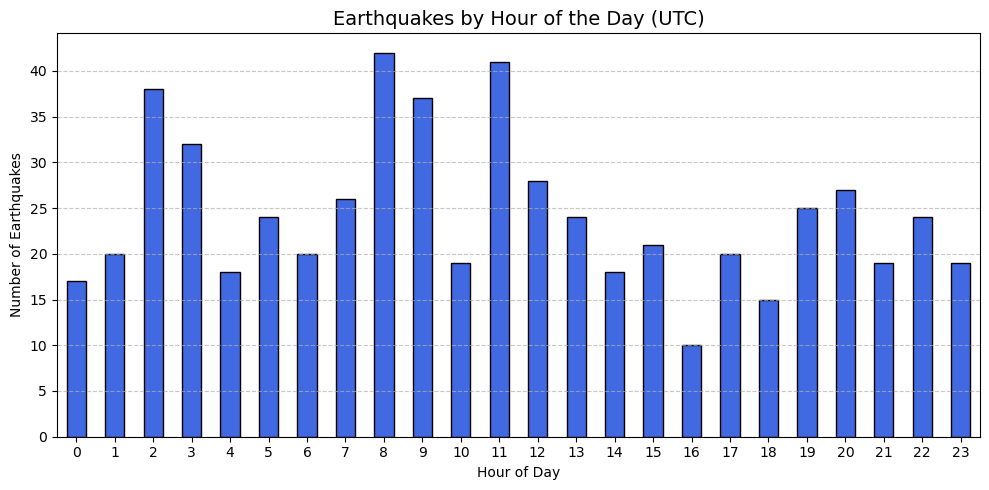

In [36]:
# Extract the timestamp of each earthquake event from the JSON response
timestamps = [pd.to_datetime(feature["properties"]["time"], unit="ms") for feature in data["features"]]

# Add the timestamps to the DataFrame
df["time"] = timestamps

# Extract the hour from each timestamp (UTC)
df["hour"] = df["time"].dt.hour

# Count the number of earthquakes for each hour
hourly_counts = df["hour"].value_counts().sort_index()

# Plot the hourly distribution of earthquakes
plt.figure(figsize=(10, 5))
hourly_counts.plot(kind="bar", color="royalblue", edgecolor="black")
plt.title("Earthquakes by Hour of the Day (UTC)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Earthquakes")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("earthquakes_by_hour.png", dpi=300)
plt.show()


In this section, we assign a regional label to each earthquake based on its geographic coordinates. We then group the data by region to compute summary statistics, including the total number of earthquakes, average magnitude, and maximum recorded magnitude for each region. A bar chart is generated to highlight the differences in average earthquake magnitude across regions, offering a clear visual comparison of seismic intensity throughout Turkey.

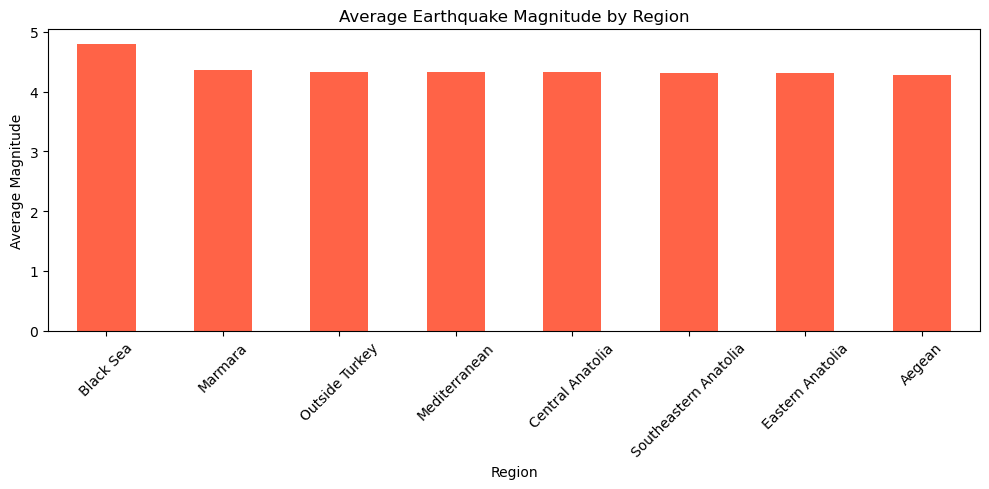

In [39]:
# Assign a region label to each earthquake event based on latitude and longitude
df["region"] = df.apply(lambda row: assign_region(row["lat"], row["lon"]), axis=1)

# Group the data by region to calculate summary statistics
region_stats = df.groupby("region").agg(
    count=("mag", "count"),       # Total number of earthquakes in the region
    mean_mag=("mag", "mean"),     # Average magnitude per region
    max_mag=("mag", "max")        # Maximum magnitude recorded in the region
).sort_values(by="mean_mag", ascending=False)

# Plot a bar chart of average magnitude by region
import matplotlib.pyplot as plt

region_stats["mean_mag"].plot(kind="bar", figsize=(10, 5), color="tomato")
plt.title("Average Earthquake Magnitude by Region")
plt.ylabel("Average Magnitude")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("average_earthquake_by_region.png", dpi=300)
plt.show()



This section visualizes the distribution of earthquake magnitudes across different regions in Turkey (excluding events that occurred outside the country). A boxplot is used to illustrate the spread, central tendency, and outliers in magnitude values for each region. This helps in comparing the variability and intensity of seismic activity between regions, providing insights into which areas tend to experience stronger or more varied earthquakes.

C:\Users\esing\AppData\Local\Temp\ipykernel_41352\2342152779.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df["region"] != "Outside Turkey"], x="region", y="mag", palette="Set2")


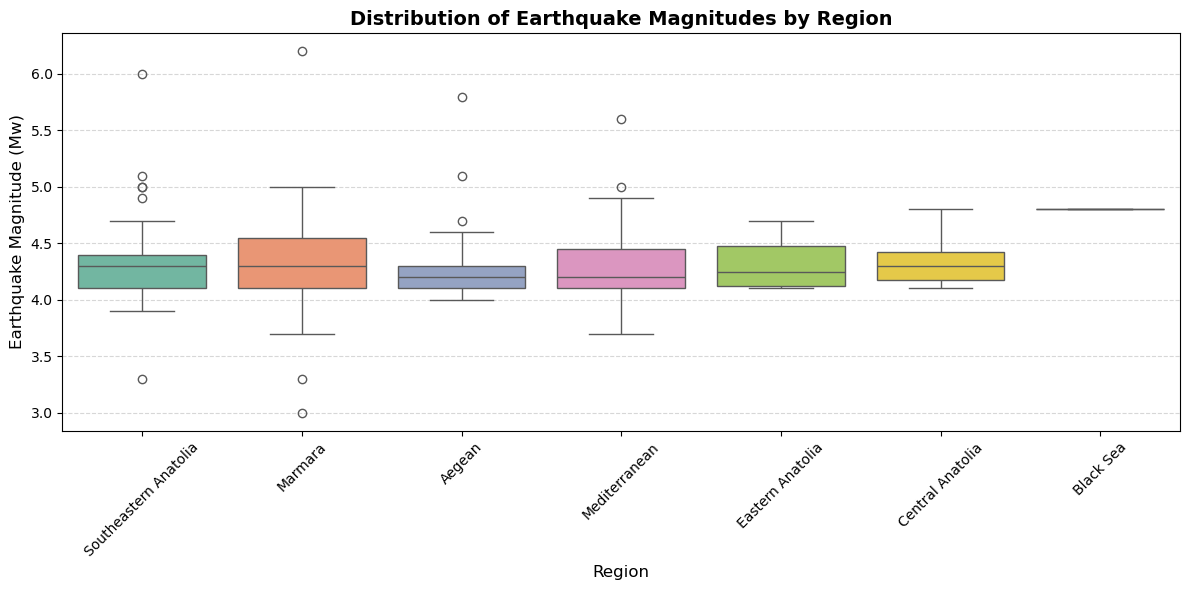

In [40]:
# Create a boxplot showing the distribution of magnitudes by region (excluding outside-Turkey events)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df["region"] != "Outside Turkey"], x="region", y="mag", palette="Set2")

plt.title("Distribution of Earthquake Magnitudes by Region", fontsize=14, weight='bold')
plt.xlabel("Region", fontsize=12)
plt.ylabel("Earthquake Magnitude (Mw)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("distribution_magnitude_by_region.png", dpi=300)
plt.show()


This section calculates the average earthquake magnitude and the total number of earthquakes for each region within Turkey. The results are visualized using a dual-axis plot: a bar chart shows the average magnitude per region, while a line plot overlays the total count of earthquakes. This combined view helps identify both the intensity and frequency of seismic activity across different Turkish regions.

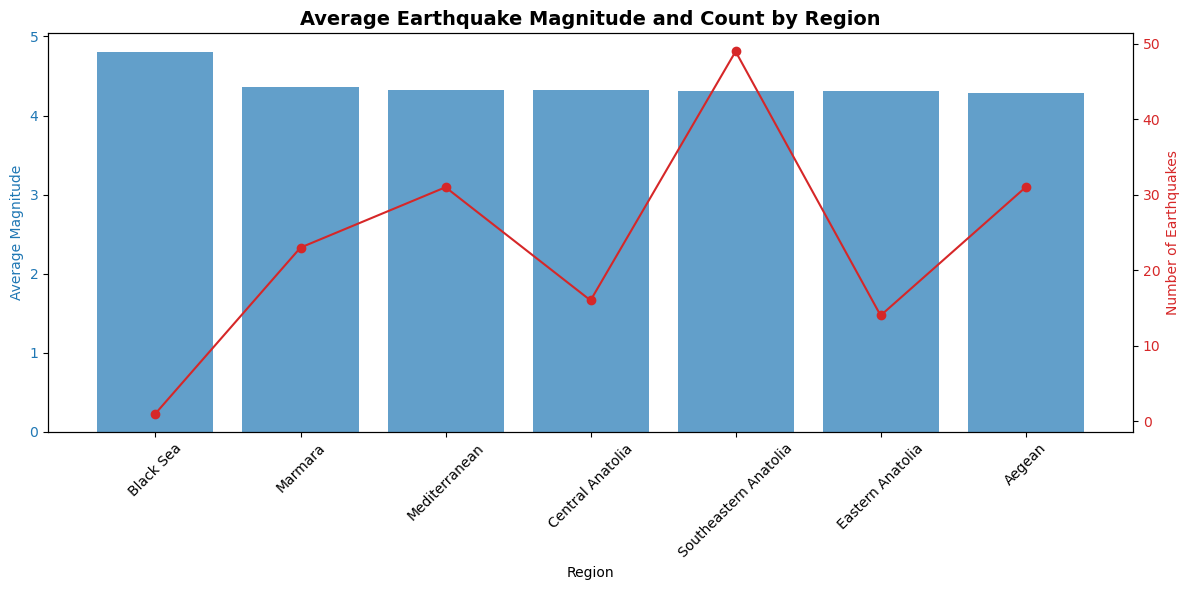

In [42]:
# Compute average magnitude and count per region, excluding 'Outside Turkey'
stats = df[df["region"] != "Outside Turkey"].groupby("region").agg(
    mean_mag=("mag", "mean"),
    count=("mag", "count")
).sort_values("mean_mag", ascending=False)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for average magnitude
color = 'tab:blue'
ax1.set_xlabel('Region')
ax1.set_ylabel('Average Magnitude', color=color)
ax1.bar(stats.index, stats["mean_mag"], color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

# Line plot for number of earthquakes
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Earthquakes', color=color)
ax2.plot(stats.index, stats["count"], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Final formatting
plt.title("Average Earthquake Magnitude and Count by Region", fontsize=14, weight='bold')
plt.tight_layout()

# Save and show the plot
plt.savefig("earthquake_region_stats.png", dpi=300)
plt.show()